In [19]:
import sys
sys.path.insert(1, '../../libs')
from utils import get_data, temporal_train_test_split
from autorship import AuthorClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import TweetTokenizer
from scipy.stats import ttest_ind, pearsonr
from statsmodels.graphics.gofplots import qqplot
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from joblib import Parallel, delayed

In [3]:
data = get_data("../../data/authors.csv")

In [4]:
tt = TweetTokenizer()

estimators = [
        ('svm', LinearSVC(random_state=42, max_iter=10000)),
        ('lr_l1', LogisticRegression(random_state=42, penalty="l1", solver="liblinear"),
        ('rf'), RandomForestClassifier(random_state=42))]
stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=42, penalty="l2", solver="liblinear"))

grid = [(MultinomialNB(), CountVectorizer(ngram_range=(1,3), analyzer="word", tokenizer=tt.tokenize)),
        (LogisticRegression(random_state=42, penalty="l1", solver="liblinear"), TfidfVectorizer(ngram_range=(1,5), analyzer="char")),
        (LogisticRegression(random_state=42, penalty="l2", solver="liblinear"), TfidfVectorizer(ngram_range=(1,1), analyzer="word", tokenizer=tt.tokenize)),
        (LinearSVC(random_state=42, max_iter=10000), TfidfVectorizer(ngram_range=(1,1), analyzer="word", tokenizer=tt.tokenize)),
        (SVC(random_state=42), TfidfVectorizer(ngram_range=(1,1), analyzer="word", tokenizer=tt.tokenize)),
        (DecisionTreeClassifier(random_state=42), CountVectorizer(ngram_range=(1,3), analyzer="word", tokenizer=tt.tokenize)),
        (RandomForestClassifier(random_state=42), CountVectorizer(ngram_range=(1,1), analyzer="word", tokenizer=tt.tokenize)),
        (AdaBoostClassifier(random_state=42), CountVectorizer(ngram_range=(1,5), analyzer="char")),
        (GradientBoostingClassifier(random_state=42), CountVectorizer(ngram_range=(1,3), analyzer="char")),
        (stacking, TfidfVectorizer(ngram_range=(1,1), analyzer="word", tokenizer=tt.tokenize))
        ]

In [7]:
from joblib import Parallel, delayed
def process(clf, vectorizer):
    clf_str = clf.__str__()
    print(f"Running ===> {clf_str}")
    evaluation = list()
    usernames = list(np.unique(data["username"]))

    for i in range(len(usernames)):
        author1 = usernames.pop()

        for author2 in usernames:
            X_train, X_test, y_train, y_test = temporal_train_test_split(   
                data, author1, author2)

            author_clf = AuthorClassifier(clf=clf, vectorizer=vectorizer, scaler=MaxAbsScaler())
            author_clf.fit(X_train["comment"], y_train)
            y_pred = author_clf.predict(X_test["comment"])
            evaluation.append(author_clf.evaluate(y_test, y_pred))

    metrics = pd.DataFrame(evaluation)
    metrics["clf"] = [clf_str for i in range(len(metrics))]

    print(f"Finish <=== {clf_str}")
    return metrics
        
results = Parallel(n_jobs=8)(delayed(process)(clf, vectorizer) for clf, vectorizer in grid)

Running ===> LogisticRegression(penalty='l1', random_state=42, solver='liblinear')
Running ===> MultinomialNB()
Running ===> LogisticRegression(random_state=42, solver='liblinear')
Running ===> AdaBoostClassifier(random_state=42)
Running ===> SVC(random_state=42)
Running ===> DecisionTreeClassifier(random_state=42)
Running ===> RandomForestClassifier(random_state=42)
Running ===> LinearSVC(max_iter=10000, random_state=42)
Finish <=== LogisticRegression(random_state=42, solver='liblinear')
Running ===> GradientBoostingClassifier(random_state=42)
Finish <=== LinearSVC(max_iter=10000, random_state=42)
Running ===> StackingClassifier(estimators=[('svm',
                                LinearSVC(max_iter=10000, random_state=42)),
                               ('lr_l1',
                                LogisticRegression(penalty='l1',
                                                   random_state=42,
                                                   solver='liblinear'),
                   

In [8]:
metrics_df = pd.concat(results)
metrics_df.sample(10)

,author1,author2,precision_author1,recall_author1,f1_score_author1,precision_author2,recall_author2,f1_score_author2,precision_weighted,precision_micro,precision_macro,recall_weighted,recall_micro,recall_macro,f1_weighted,f1_micro,f1_macro,auc_score,accuracy,clf
13,um--no,xanax101010,0.9634,0.9518,0.9576,0.9512,0.9630,0.9571,0.9574,0.9573,0.9573,0.9573,0.9573,0.9574,0.9573,0.9573,0.9573,0.9836,0.9573,"LogisticRegression(penalty='l1', random_state=..."
41,BeatoSalut,logatwork,0.8228,0.8531,0.8377,0.8442,0.8125,0.8280,0.8334,0.8330,0.8335,0.8330,0.8330,0.8328,0.8329,0.8330,0.8329,0.9031,0.8330,AdaBoostClassifier(random_state=42)
42,BluePirate89,logatwork,0.9111,0.6640,0.7681,0.7296,0.9333,0.8190,0.8217,0.7967,0.8204,0.7967,0.7967,0.7987,0.7932,0.7967,0.7936,0.9061,0.7967,SVC(random_state=42)
84,9-Cortes,MaxVonHabsburg,0.9076,0.8675,0.8871,0.8690,0.9087,0.8884,0.8886,0.8878,0.8883,0.8878,0.8878,0.8881,0.8877,0.8878,0.8878,0.9610,0.8878,"StackingClassifier(estimators=[('svm',\n ..."
22,Miteiro,um--no,0.9050,0.8475,0.8753,0.8636,0.9157,0.8889,0.8838,0.8825,0.8843,0.8825,0.8825,0.8816,0.8823,0.8825,0.8821,0.9475,0.8825,GradientBoostingClassifier(random_state=42)
39,9-Cortes,logatwork,0.8930,0.8715,0.8821,0.8699,0.8917,0.8807,0.8817,0.8814,0.8815,0.8814,0.8814,0.8816,0.8814,0.8814,0.8814,0.9432,0.8814,"LogisticRegression(penalty='l1', random_state=..."
47,Miteiro,logatwork,0.8268,0.8898,0.8571,0.8829,0.8167,0.8485,0.8551,0.8529,0.8548,0.8529,0.8529,0.8532,0.8528,0.8529,0.8528,0.9292,0.8529,AdaBoostClassifier(random_state=42)
27,9-Cortes,piperman_,0.8973,0.8072,0.8499,0.8065,0.8969,0.8493,0.8544,0.8496,0.8519,0.8496,0.8496,0.8520,0.8496,0.8496,0.8496,0.9350,0.8496,"LinearSVC(max_iter=10000, random_state=42)"
59,Supermunch2000,TheGza1,0.7138,0.8916,0.7929,0.8412,0.6164,0.7114,0.7753,0.7588,0.7775,0.7588,0.7588,0.7540,0.7536,0.7588,0.7521,0.8272,0.7588,SVC(random_state=42)
55,Manada_2,TheGza1,0.9207,0.8601,0.8894,0.8629,0.9224,0.8917,0.8925,0.8905,0.8918,0.8905,0.8905,0.8912,0.8905,0.8905,0.8905,0.9432,0.8905,"LinearSVC(max_iter=10000, random_state=42)"


In [20]:
keys = metrics_df.clf.unique()
values = ['Naive Bayes Multinomial',
        'Regressão Logística (L1)',
        'Regressão Logística (L2)',
        'SVM (kernel linear)',
        'SVM (kernel rbf)',
        'Árvore de Decisão',
        'Random Forest',
        'AdaBoost',
        'Gradient boosting',
        'Stacking']

dict_clf = dict(zip(keys, values))

In [21]:
metrics_df["clf"] = metrics_df["clf"].map(dict_clf)

In [39]:
metrics_df.to_csv("../../results/otimal_results.csv")

In [ ]:
# import numpy as np, scipy.stats as st
# import matplotlib.pyplot as plt
# import seaborn as sns

# lim_inf, lim_sup = st.t.interval(0.95, len(metrics["accuracy"])-1, loc=metrics["accuracy"].mean(), scale=st.sem(metrics["accuracy"]))
# sns.displot(metrics["accuracy"], kde=True)
# plt.axvline(lim_inf, color="red")
# plt.axvline(lim_sup, color="red")

In [4]:
metrics_df = pd.read_csv("../../results/otimal_results.csv").drop("Unnamed: 0", axis=1)

In [5]:
metrics_df

,author1,author2,precision_author1,recall_author1,f1_score_author1,precision_author2,recall_author2,f1_score_author2,precision_weighted,precision_micro,precision_macro,recall_weighted,recall_micro,recall_macro,f1_weighted,f1_micro,f1_macro,auc_score,accuracy,clf
0,9-Cortes,xanax101010,0.7697,0.9799,0.8622,0.9714,0.6996,0.8134,0.8693,0.8415,0.8706,0.8415,0.8415,0.8398,0.8381,0.8415,0.8378,0.9316,0.8415,Naive Bayes Multinomial
1,AgnaldoTeExplode,xanax101010,0.7926,0.9145,0.8492,0.9034,0.7695,0.8311,0.8490,0.8407,0.8480,0.8407,0.8407,0.8420,0.8400,0.8407,0.8402,0.8990,0.8407,Naive Bayes Multinomial
2,BeatoSalut,xanax101010,0.8210,0.8612,0.8406,0.8528,0.8107,0.8312,0.8368,0.8361,0.8369,0.8361,0.8361,0.8360,0.8359,0.8361,0.8359,0.9223,0.8361,Naive Bayes Multinomial
3,BluePirate89,xanax101010,0.8036,0.5466,0.6506,0.6522,0.8642,0.7434,0.7285,0.7041,0.7279,0.7041,0.7041,0.7054,0.6966,0.7041,0.6970,0.8541,0.7041,Naive Bayes Multinomial
4,CariocaSatanico,xanax101010,0.7492,0.9839,0.8507,0.9758,0.6626,0.7892,0.8611,0.8252,0.8625,0.8252,0.8252,0.8232,0.8203,0.8252,0.8200,0.9327,0.8252,Naive Bayes Multinomial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,AgnaldoTeExplode,BluePirate89,0.9450,0.8803,0.9115,0.8935,0.9514,0.9216,0.9186,0.9168,0.9192,0.9168,0.9168,0.9159,0.9167,0.9168,0.9165,0.9570,0.9168,Stacking
1046,BeatoSalut,BluePirate89,0.7500,0.8082,0.7780,0.7939,0.7328,0.7621,0.7720,0.7703,0.7719,0.7703,0.7703,0.7705,0.7700,0.7703,0.7701,0.8766,0.7703,Stacking
1047,9-Cortes,BeatoSalut,0.8440,0.8474,0.8457,0.8443,0.8408,0.8425,0.8441,0.8441,0.8441,0.8441,0.8441,0.8441,0.8441,0.8441,0.8441,0.9262,0.8441,Stacking
1048,AgnaldoTeExplode,BeatoSalut,0.8156,0.8504,0.8326,0.8511,0.8163,0.8333,0.8337,0.8330,0.8333,0.8330,0.8330,0.8334,0.8330,0.8330,0.8330,0.9268,0.8330,Stacking


Text(0, 0.5, 'Acurácia')

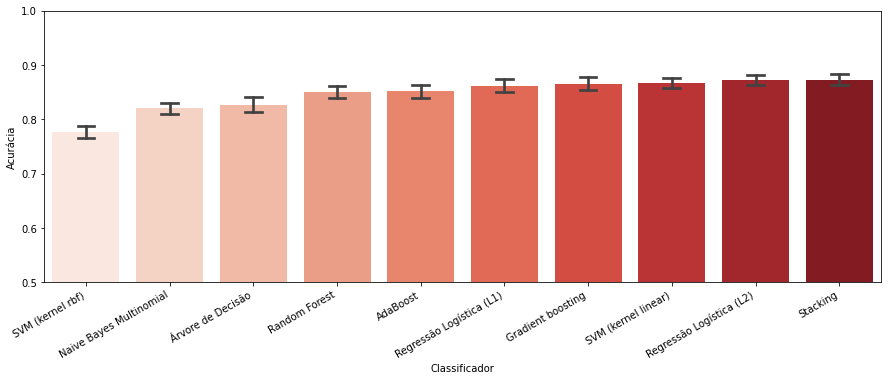

In [6]:
font = {'size': 12}

matplotlib.rc('font', **font)

plt.figure(figsize=(15,5))
plt.ylim(0.5, 1)
plt.xticks(rotation=30, ha='right')
sns.barplot(x='clf', y='accuracy', data=metrics_df, estimator=np.mean, ci=95, capsize=.2,palette="Reds", order=metrics_df.groupby("clf").mean()["accuracy"].sort_values().reset_index()["clf"])
plt.xlabel('Classificador')
plt.ylabel('Acurácia')

Text(0, 0.5, 'F1-score')

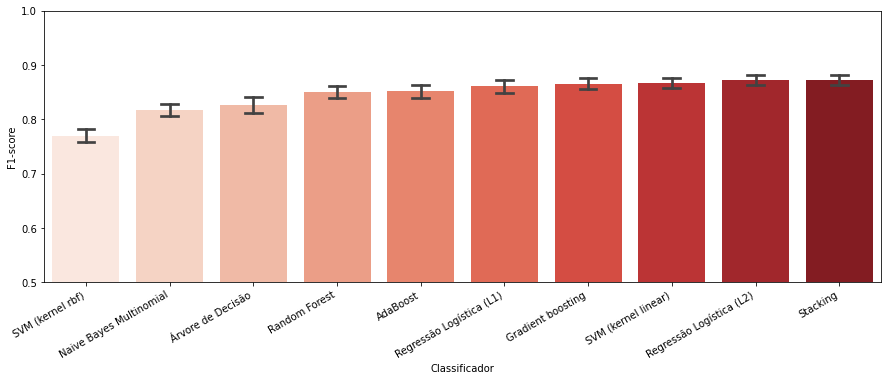

In [7]:
plt.figure(figsize=(15,5))
plt.ylim(0.5, 1)
plt.xticks(rotation=30, ha='right')
sns.barplot(x='clf', y='f1_macro', data=metrics_df, estimator=np.mean, ci=95, capsize=.2,palette="Reds", order=metrics_df.groupby("clf").mean()["f1_macro"].sort_values().reset_index()["clf"])
plt.xlabel('Classificador')
plt.ylabel('F1-score')

Text(0, 0.5, 'AUC')

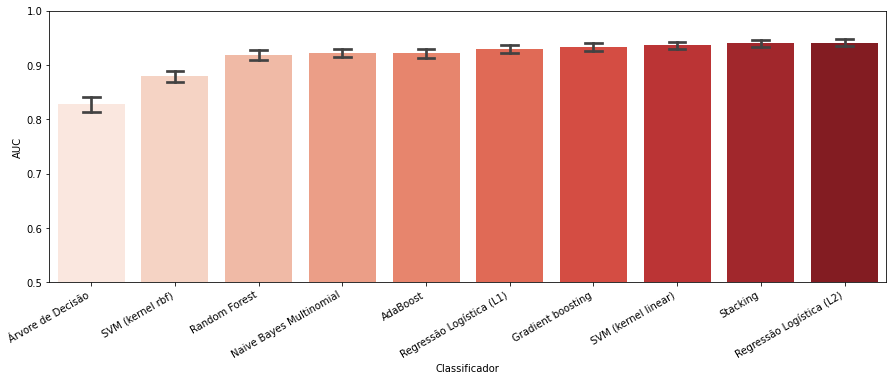

In [8]:
plt.figure(figsize=(15,5))
plt.ylim(0.5, 1)
plt.xticks(rotation=30, ha='right')
sns.barplot(x='clf', y='auc_score', data=metrics_df, estimator=np.mean, ci=95, capsize=.2, palette="Reds", order=metrics_df.groupby("clf").mean()["auc_score"].sort_values().reset_index()["clf"])
plt.xlabel('Classificador')
plt.ylabel('AUC')

Text(0, 0.5, 'Acurácia')

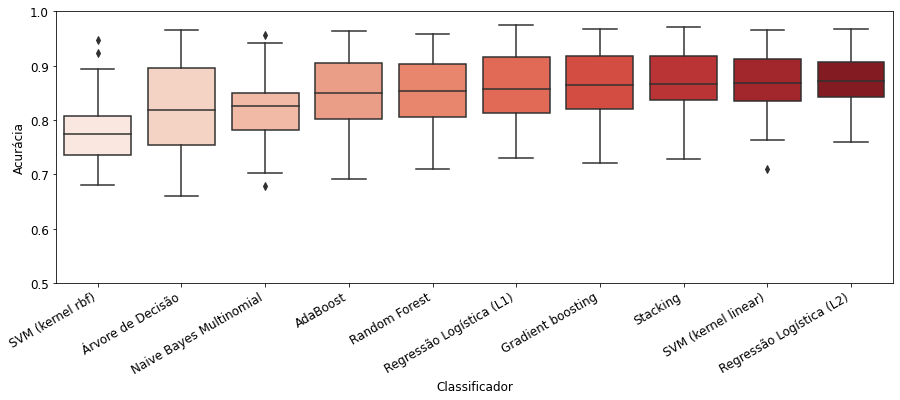

In [9]:
font = {'size': 12}

matplotlib.rc('font', **font)

plt.figure(figsize=(15,5))
plt.ylim(0.5, 1)
plt.xticks(rotation=30, ha='right')
sns.boxplot(x='clf', y='accuracy', data=metrics_df, palette="Reds", order=metrics_df.groupby("clf").median()["accuracy"].sort_values().reset_index()["clf"])
plt.xlabel('Classificador')
plt.ylabel('Acurácia')

Text(0, 0.5, 'F1-score')

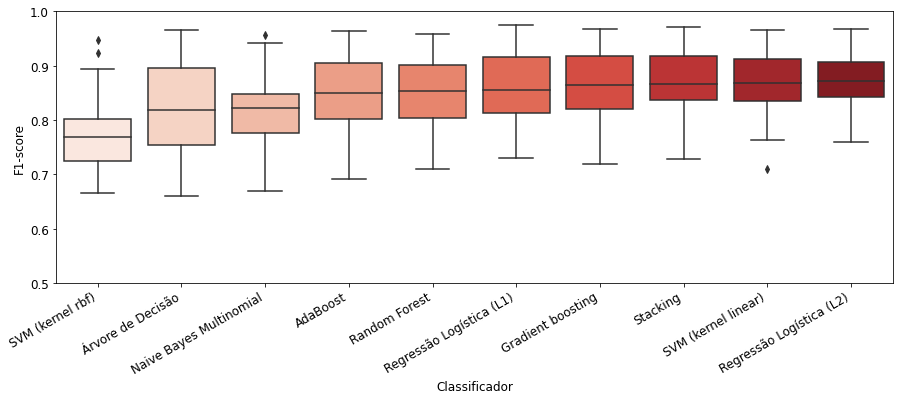

In [10]:
font = {'size': 12}

matplotlib.rc('font', **font)

plt.figure(figsize=(15,5))
plt.ylim(0.5, 1)
plt.xticks(rotation=30, ha='right')
sns.boxplot(x='clf', y='f1_macro', data=metrics_df, palette="Reds", order=metrics_df.groupby("clf").median()["f1_macro"].sort_values().reset_index()["clf"])
plt.xlabel('Classificador')
plt.ylabel('F1-score')

Text(0, 0.5, 'Área sobre a curva ROC')

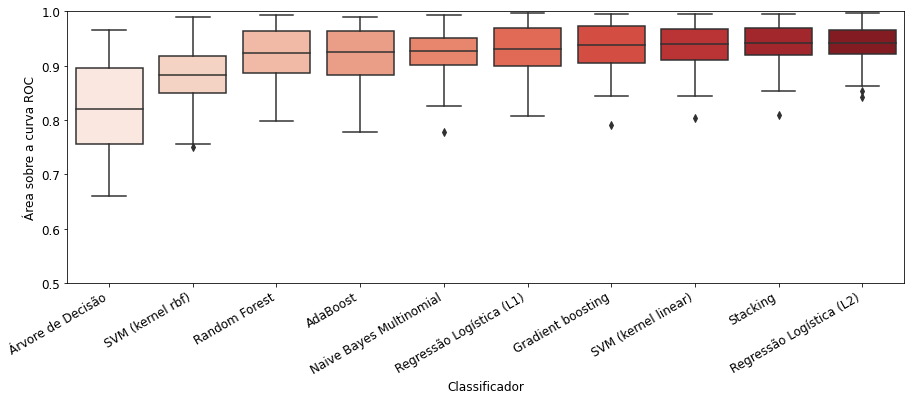

In [11]:
font = {'size': 12}

matplotlib.rc('font', **font)

plt.figure(figsize=(15,5))
plt.ylim(0.5, 1)
plt.xticks(rotation=30, ha='right')
sns.boxplot(x='clf', y='auc_score', data=metrics_df, palette="Reds", order=metrics_df.groupby("clf").median()["auc_score"].sort_values().reset_index()["clf"])
plt.xlabel('Classificador')
plt.ylabel('Área sobre a curva ROC')

Text(0, 0.5, 'Área sobre a curva ROC')

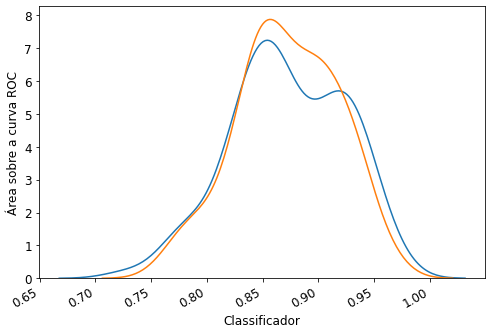

In [12]:
font = {'size': 12}

matplotlib.rc('font', **font)

plt.figure(figsize=(8,5))
plt.xticks(rotation=30, ha='right')
sns.kdeplot('f1_macro', data=metrics_df[metrics_df.clf=="Stacking"])
sns.kdeplot('f1_macro', data=metrics_df[metrics_df.clf=="Regressão Logística (L2)"])
plt.xlabel('Classificador')
plt.ylabel('Área sobre a curva ROC')

In [30]:
print(metrics_df[metrics_df.clf=="Regressão Logística (L2)"]["f1_macro"].median())
print(metrics_df[metrics_df.clf=="Stacking"]["f1_macro"].median())

0.8715
0.8666


In [14]:
print(metrics_df[metrics_df.clf=="Regressão Logística (L2)"]["f1_macro"].mean())
print(metrics_df[metrics_df.clf=="Stacking"]["f1_macro"].mean())

0.8721123809523811
0.8725333333333334


In [32]:
data1 = metrics_df[metrics_df.clf=="Regressão Logística (L2)"]["f1_macro"]
data2 = metrics_df[metrics_df.clf=="Stacking"]["f1_macro"]
stat, p = ttest_ind(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Provavelmente as mesmas distribuições')
else:
	print('Provavelmente distribuições diferentes')

stat=-0.063, p=0.950
Provavelmente as mesmas distribuições


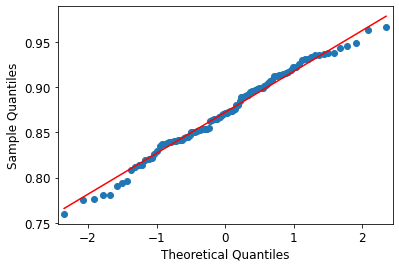

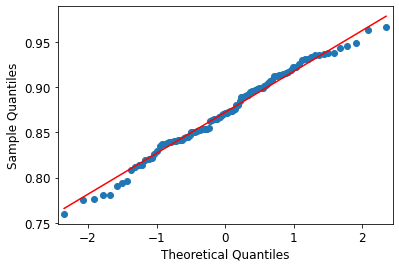

In [25]:
qqplot(data1, line='s')

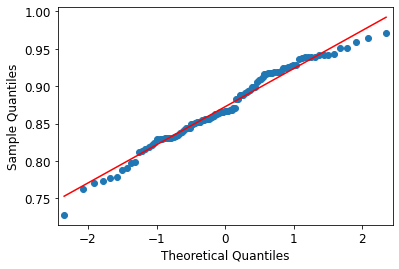

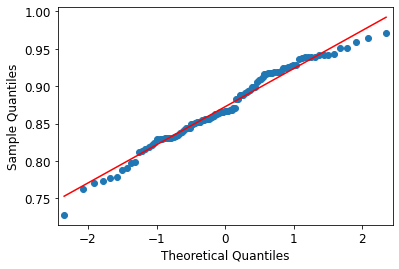

In [21]:
qqplot(data2, line='s')

In [26]:
from scipy.stats import shapiro
stat, p = shapiro(data1)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
	print('Provavelmente gaussiana')
else:
	print('Provavelmente não gaussiana')


Statistics=0.986, p=0.334
Provavelmente gaussiana
